In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
import kagglehub

In [30]:
# Load dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Dataset path:", path)

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Class Names: {class_names}")
print(f"Number of classes: {num_classes}")


Dataset path: /kaggle/input/brain-tumor-mri-dataset
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4



=== EDA ===



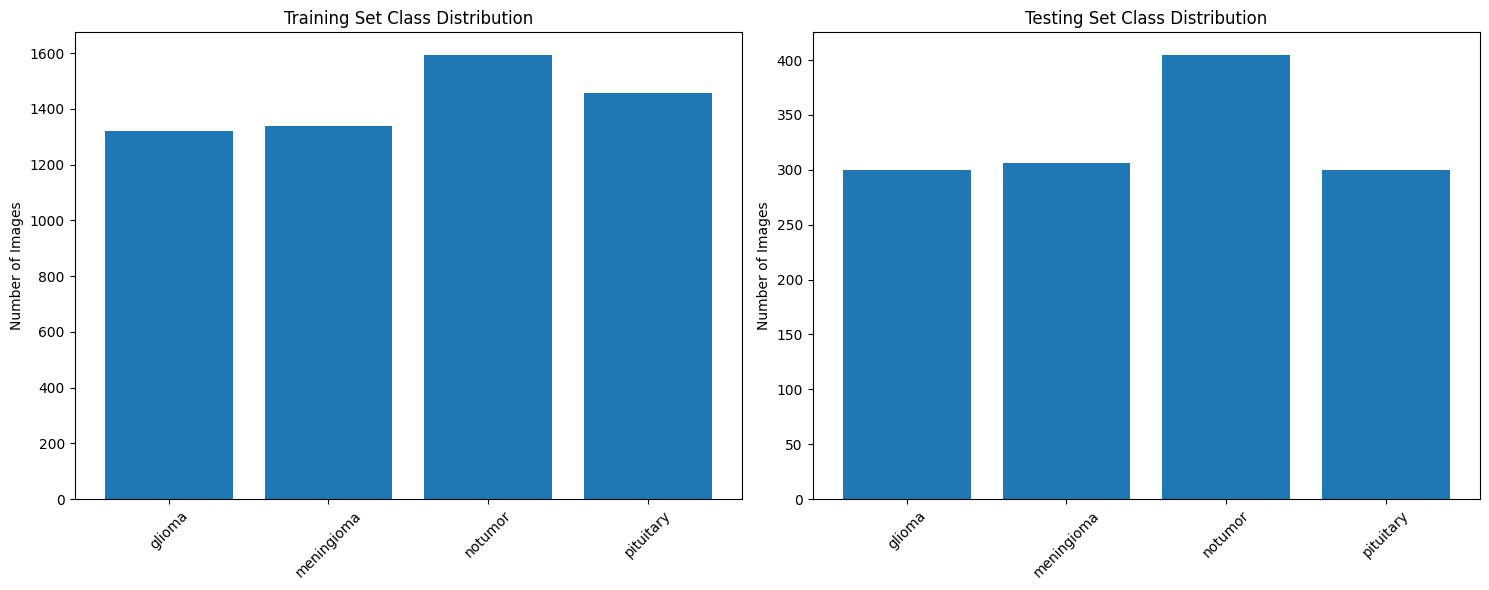

In [31]:
print("\n=== EDA ===\n")

# Count number of images in each class for training and testing
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

# Plot class distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Testing Set Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


In [32]:
# Image preprocessing
img_size = (150, 150)
optimizers = {
    'adam': Adam(),
    'sgd': SGD(),
    'rmsprop': RMSprop()
}
batch_size_options = [32, 64, 128]
input_shape = (150, 150, 3)

In [33]:
# Data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
# Model definitions
def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_dnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [35]:

# Dictionary to store all models and their histories
all_models = {}
all_histories = {}

In [37]:
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Image preprocessing
img_size = (150, 150)
batch_size_options = [32, 64, 128]
input_shape = (150, 150, 3)

# Optimizer creation function
def get_optimizer(opt_name):
    if opt_name == 'adam':
        return Adam()
    elif opt_name == 'sgd':
        return SGD()
    elif opt_name == 'rmsprop':
        return RMSprop()
    else:
        raise ValueError(f"Unsupported optimizer: {opt_name}")

# Initialize dictionaries to store models and training histories
all_models = {}
all_histories = {}

# Train models with different configurations
for batch_size in batch_size_options:
    # Create data generators for current batch size
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    for opt_name in ['adam', 'sgd', 'rmsprop']:
        # Create a fresh instance of the optimizer every time
        optimizer = get_optimizer(opt_name)

        # CNN Model
        cnn_model = create_cnn(input_shape, num_classes)
        cnn_model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

        model_name = f'cnn_{opt_name}_bs{batch_size}'
        print(f"\nTraining {model_name}...")

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = cnn_model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=10,
            validation_data=val_generator,
            validation_steps=val_generator.samples // batch_size,
            callbacks=[early_stopping],
            verbose=1)

        all_models[model_name] = cnn_model
        all_histories[model_name] = history.history

        # DNN Model
        # Create a fresh optimizer again for DNN
        optimizer = get_optimizer(opt_name)

        dnn_model = create_dnn(input_shape, num_classes)
        dnn_model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

        model_name = f'dnn_{opt_name}_bs{batch_size}'
        print(f"\nTraining {model_name}...")

        history = dnn_model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=10,
            validation_data=val_generator,
            validation_steps=val_generator.samples // batch_size,
            callbacks=[early_stopping],
            verbose=1)

        all_models[model_name] = dnn_model
        all_histories[model_name] = history.history

# Evaluate all models on test set
# Use a fixed batch size for evaluation (commonly 32)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

results = {}


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Training cnn_adam_bs32...
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.4247 - loss: 1.2161 - val_accuracy: 0.6482 - val_loss: 1.0407
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6250 - loss: 0.8433 - val_accuracy: 0.6259 - val_loss: 1.0302
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.6577 - loss: 0.7838 - val_accuracy: 0.6634 - val_loss: 0.8814
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7500 - loss: 0.5319 - val_accuracy: 0.6429 - val_loss: 0.9421
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.7188 - loss: 0.6711 - val_accuracy: 0.6705 - val_loss: 0.8870
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7500 - loss: 0.5849 - val_accuracy: 0.6804 - val_loss: 0.8931
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy

In [38]:
for model_name, model in all_models.items():
    print(f"\nEvaluating {model_name}...")
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Classification report
    report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # ROC curve data (for multi-class)
    y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    results[model_name] = {
        'accuracy': test_acc,
        'loss': test_loss,
        'report': report,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'history': all_histories[model_name]
    }



Evaluating cnn_adam_bs32...
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.5108 - loss: 1.6496
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step

Evaluating dnn_adam_bs32...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2149 - loss: 1.3998
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step

Evaluating cnn_sgd_bs32...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5253 - loss: 1.2483
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

Evaluating dnn_sgd_bs32...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5309 - loss: 1.3149
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluating cnn_rmsprop_bs32...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5466 - loss: 1.2537
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

Evaluating dnn_rmsprop_bs32...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3109 - loss: 1.3047
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step

Evaluating cnn_adam_bs64...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5507 - loss: 1.3478
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step

Evaluating dnn_adam_bs64...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2555 - loss: 1.4680
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step

Evaluating cnn_sgd_bs64...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4126 - loss: 1.4269
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step

Evaluating dnn_sgd_bs64...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2031 - loss: 1.4485
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step

Evaluating cnn_rmsprop_bs64...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3909 - loss: 1.8421
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== ROC Curves ===



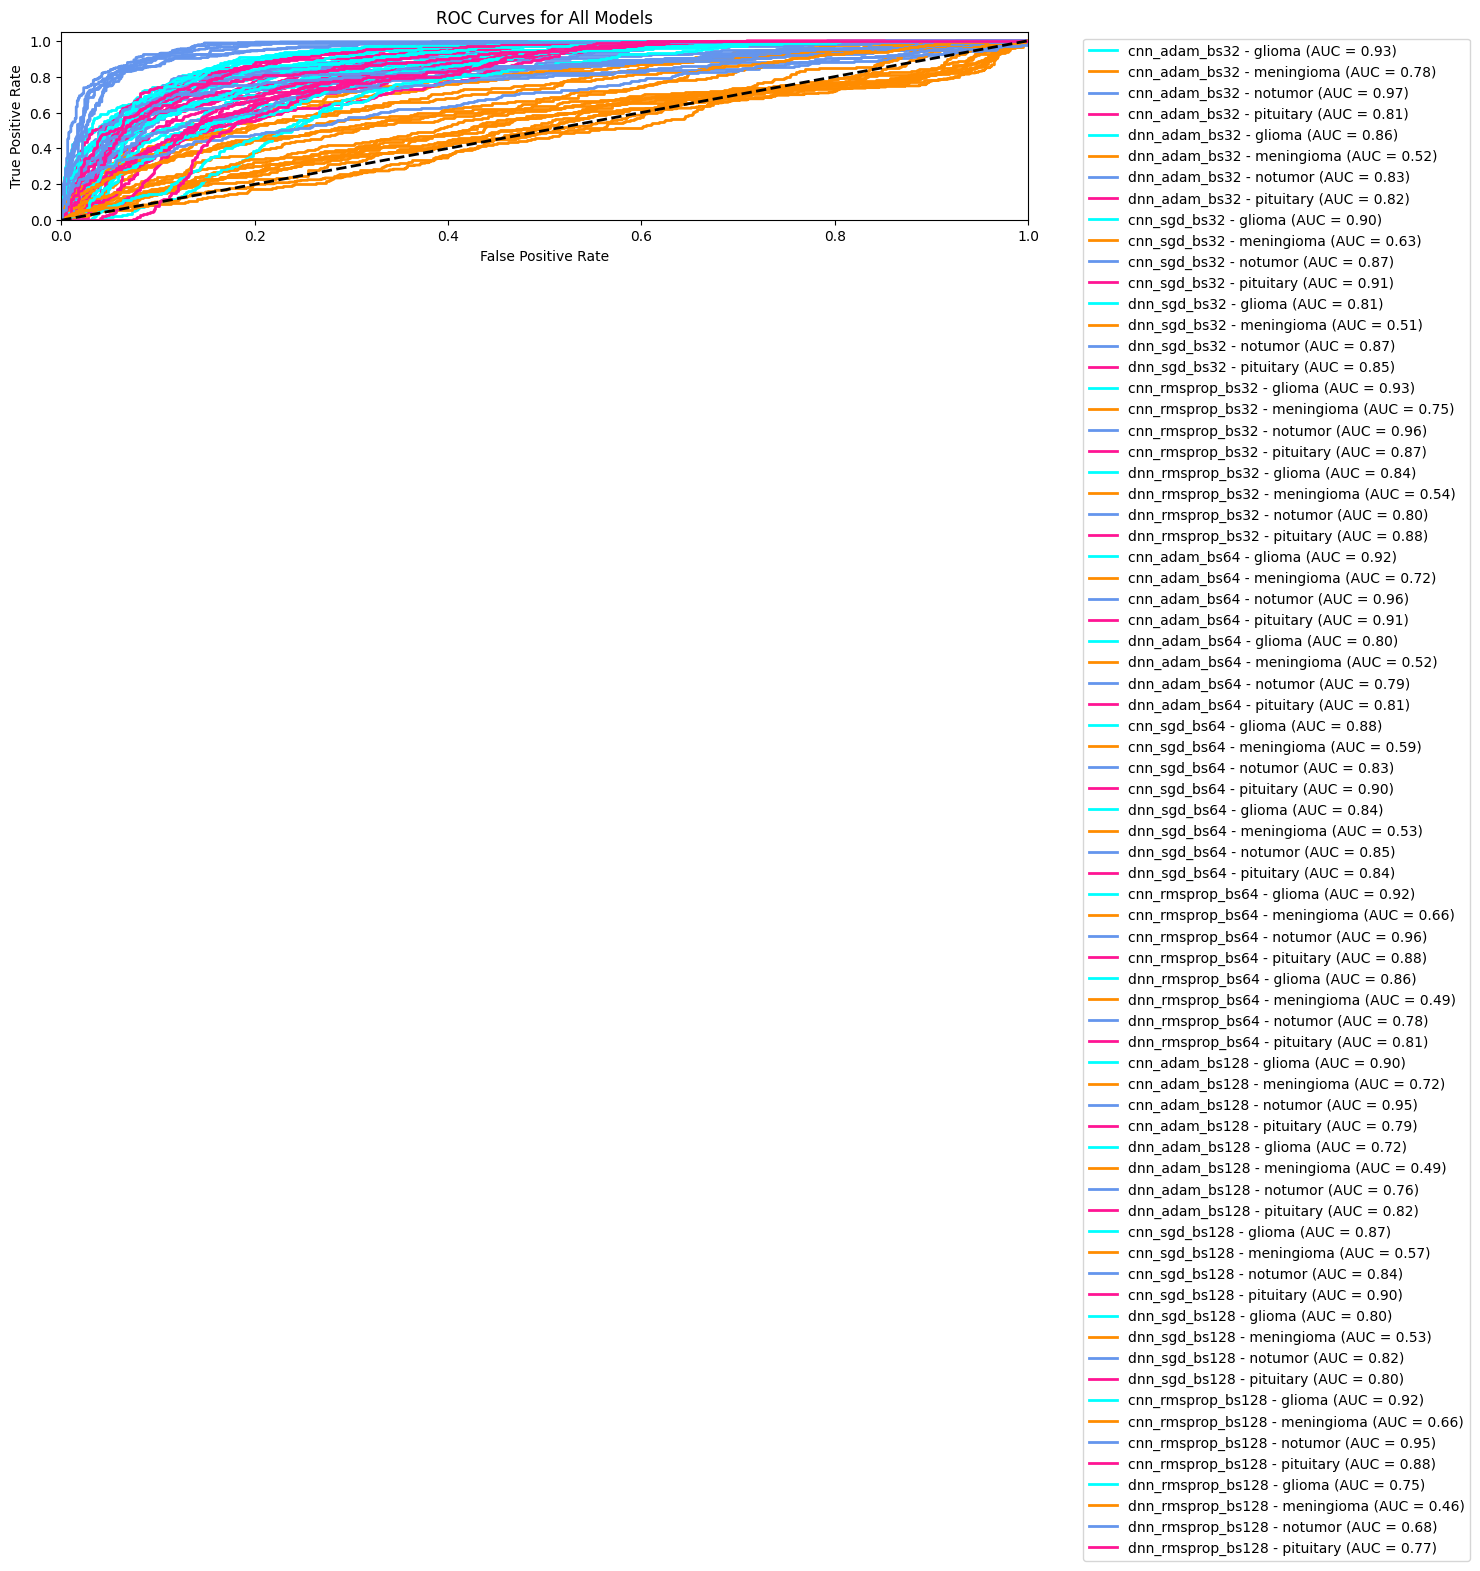

In [39]:
print("\n=== ROC Curves ===\n")
plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])

for model_name, result in results.items():
    fpr = result['fpr']
    tpr = result['tpr']
    roc_auc = result['roc_auc']

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_name} - {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


=== Confusion Matrices ===



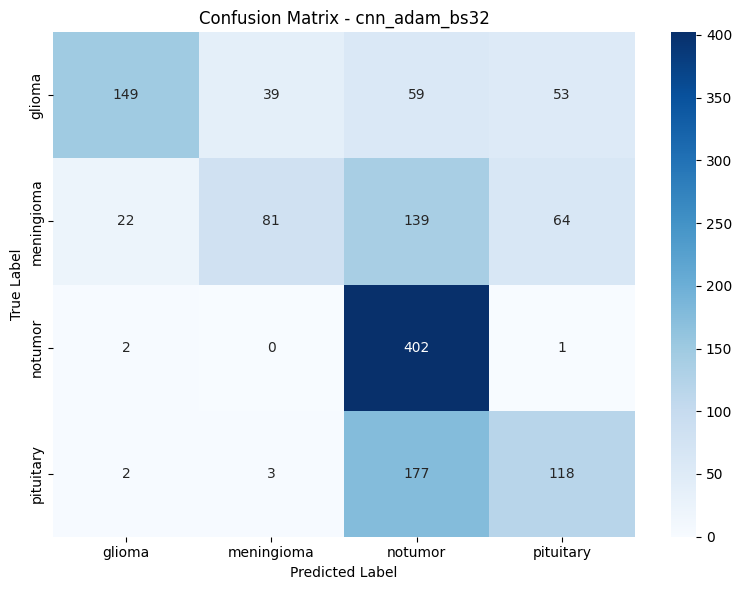

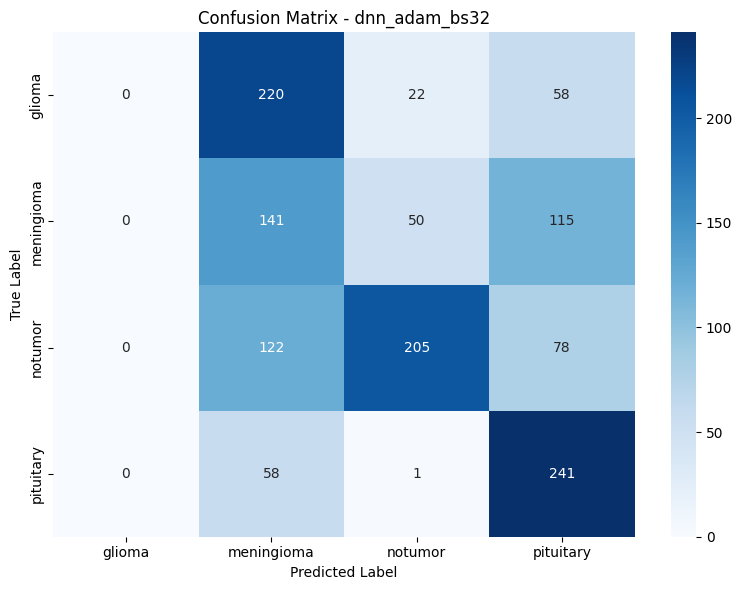

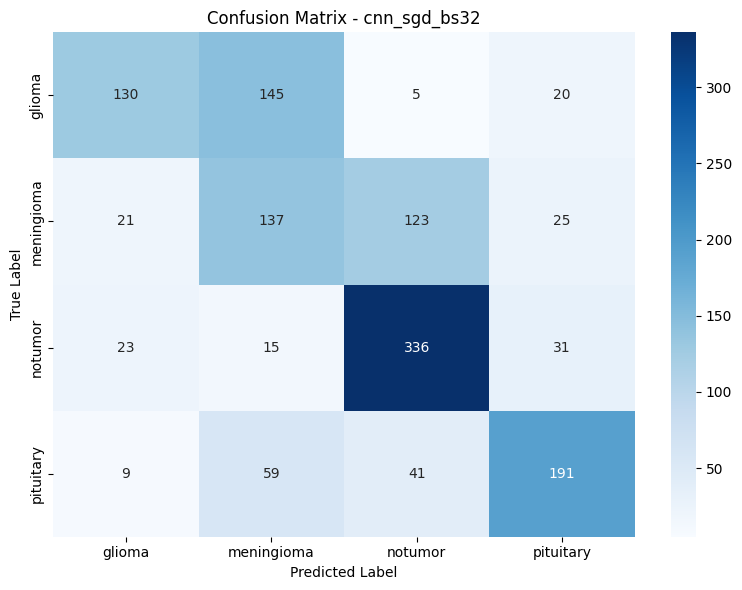

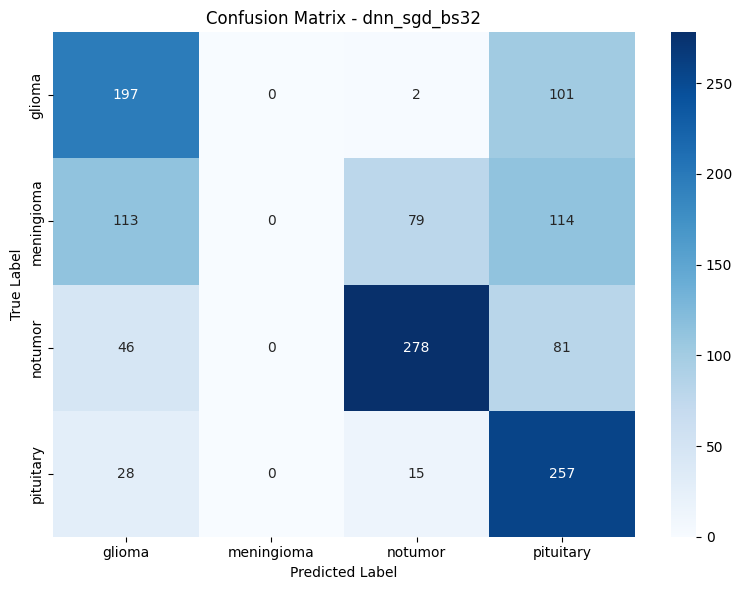

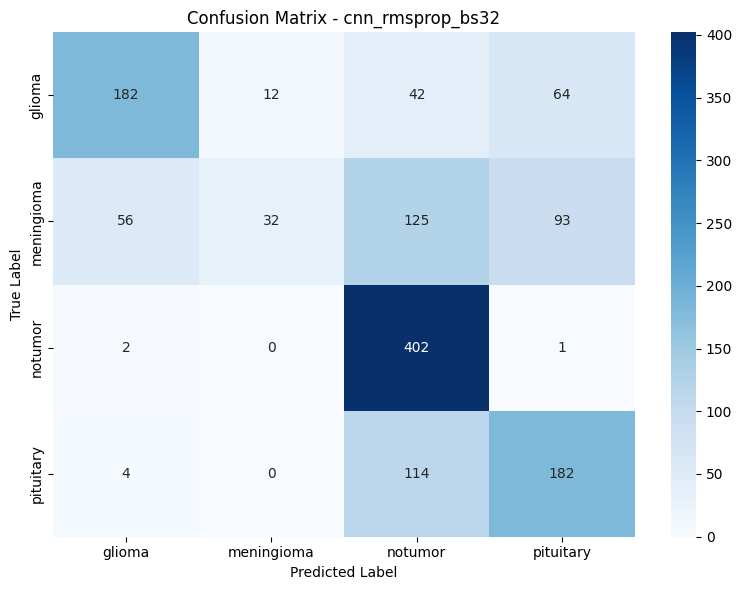

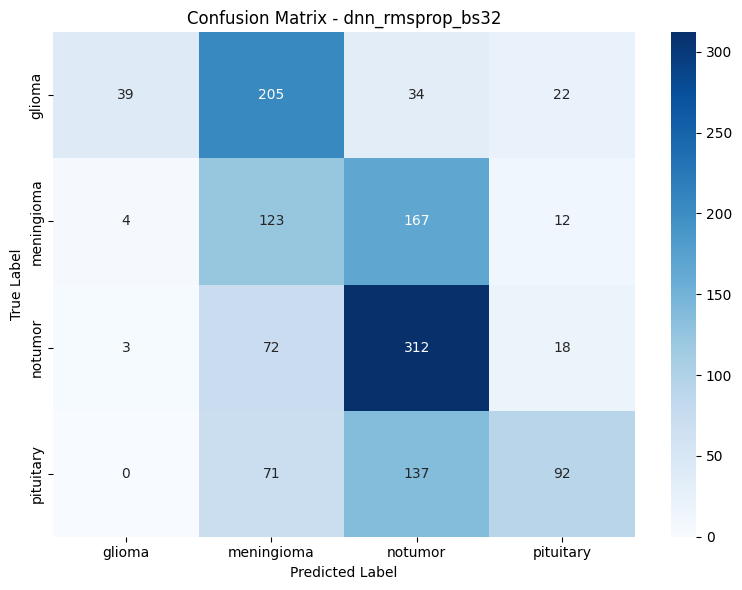

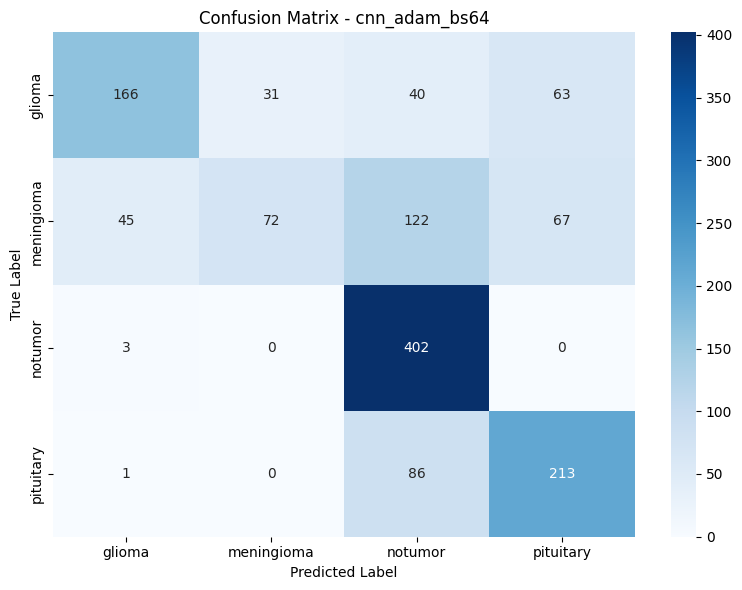

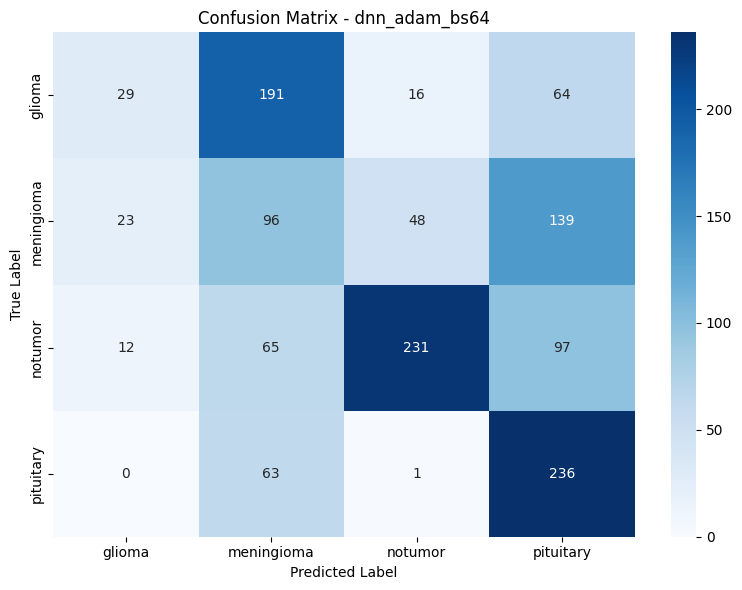

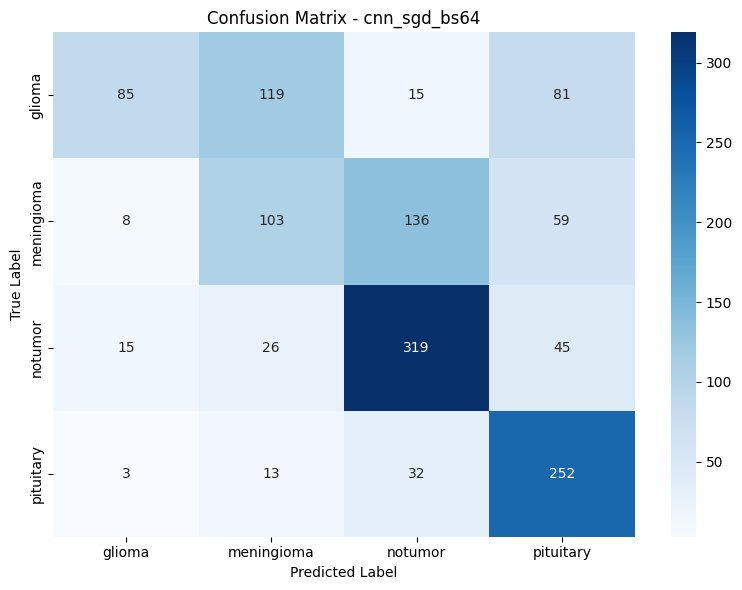

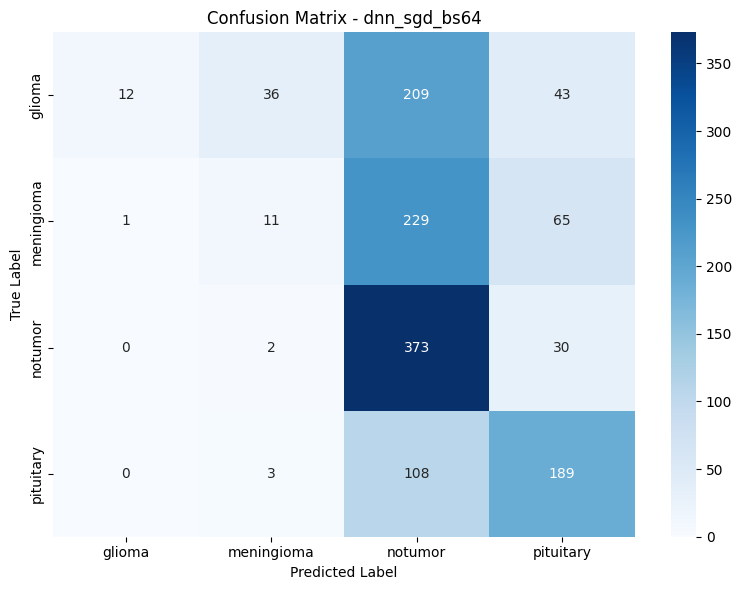

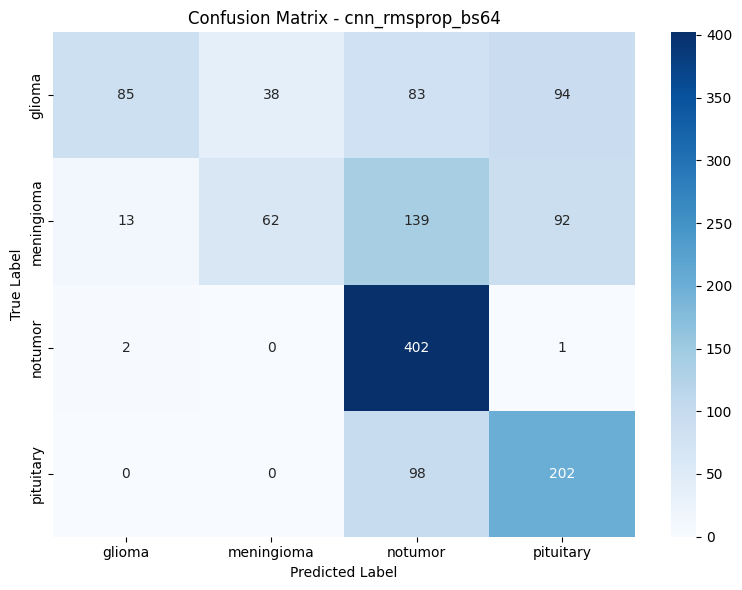

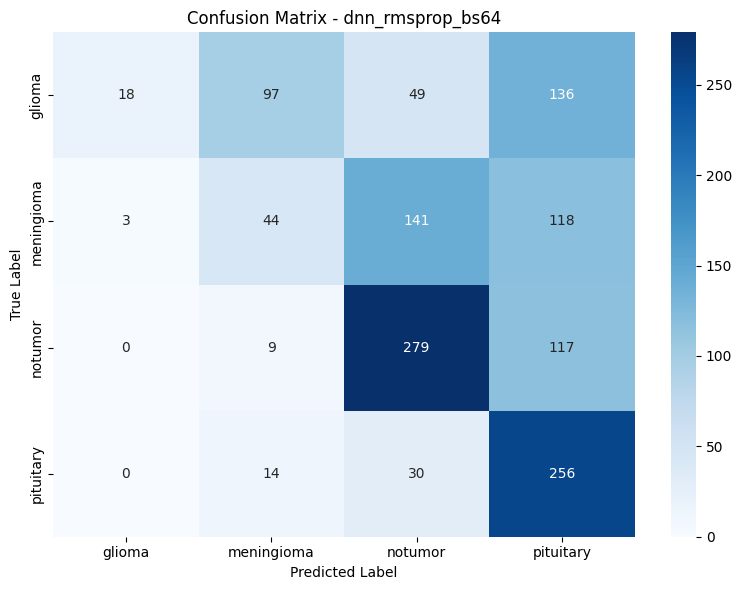

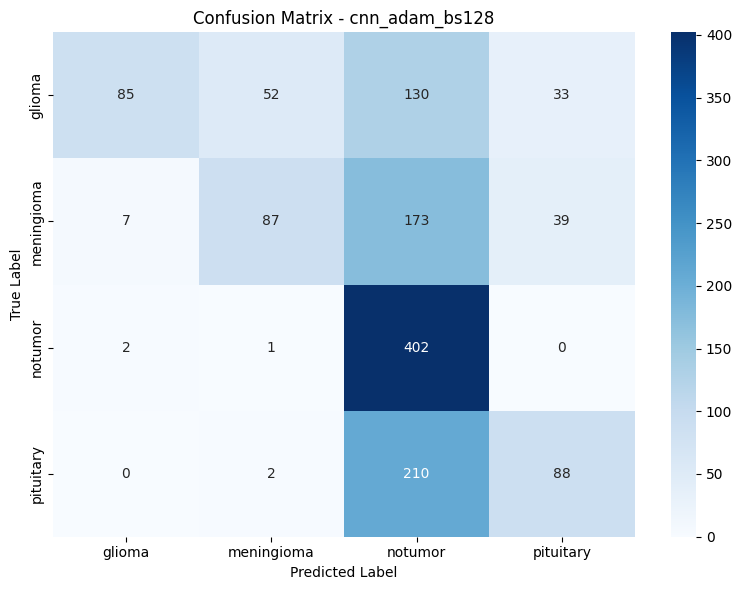

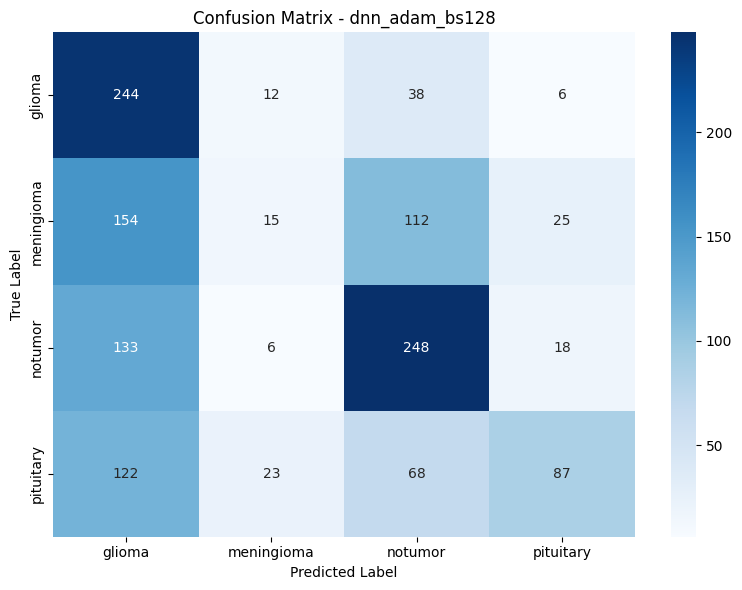

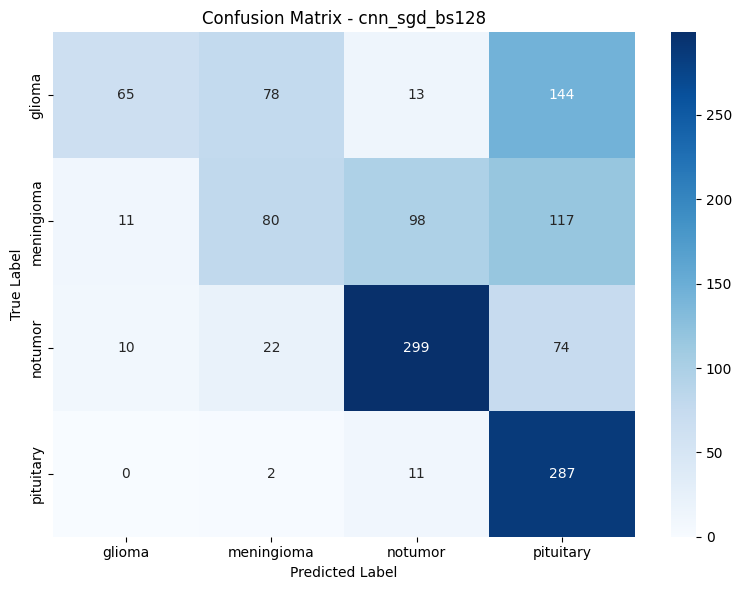

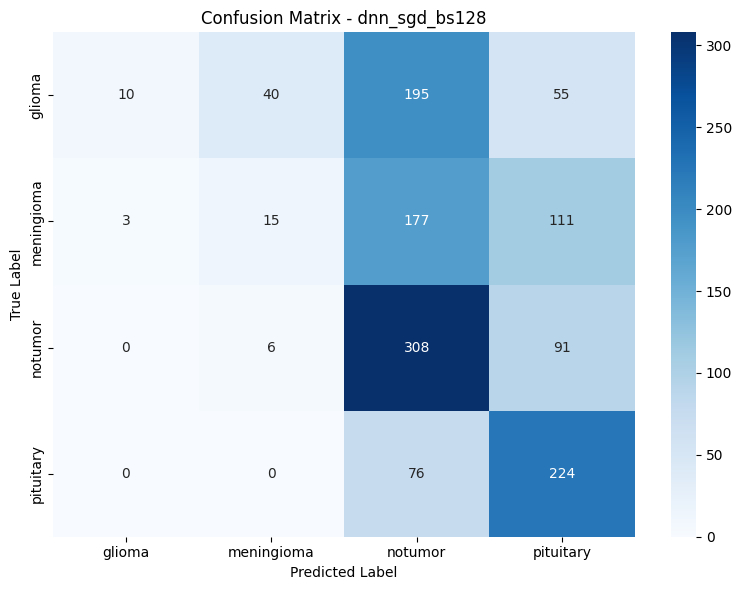

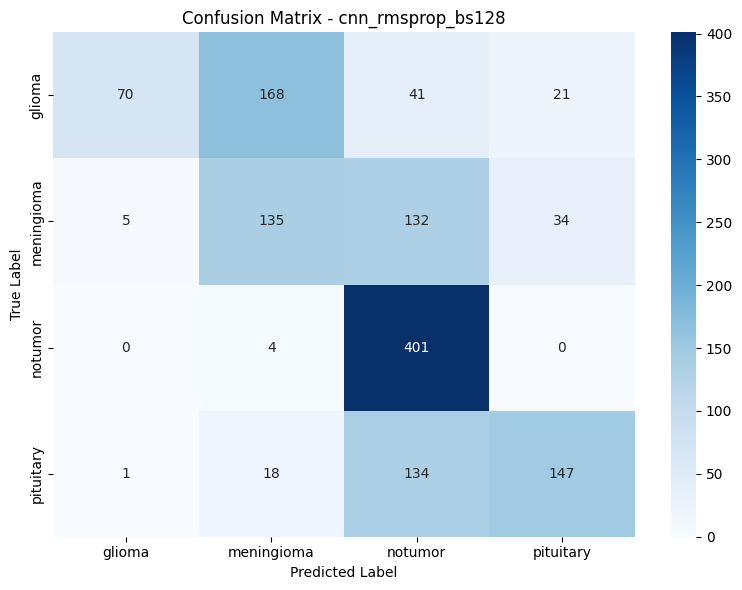

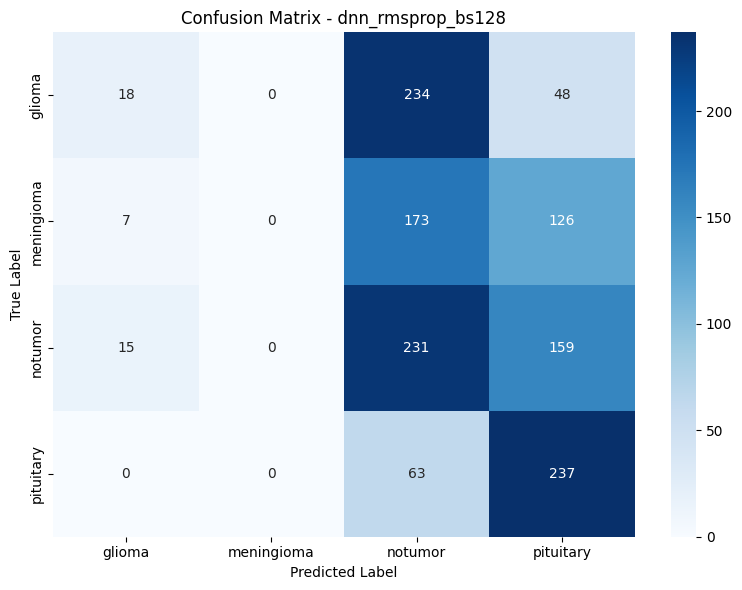

In [40]:
print("\n=== Confusion Matrices ===\n")
for model_name in all_models.keys():
    cm = results[model_name]['confusion_matrix']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

<ipython-input-48-6f28126a9738>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


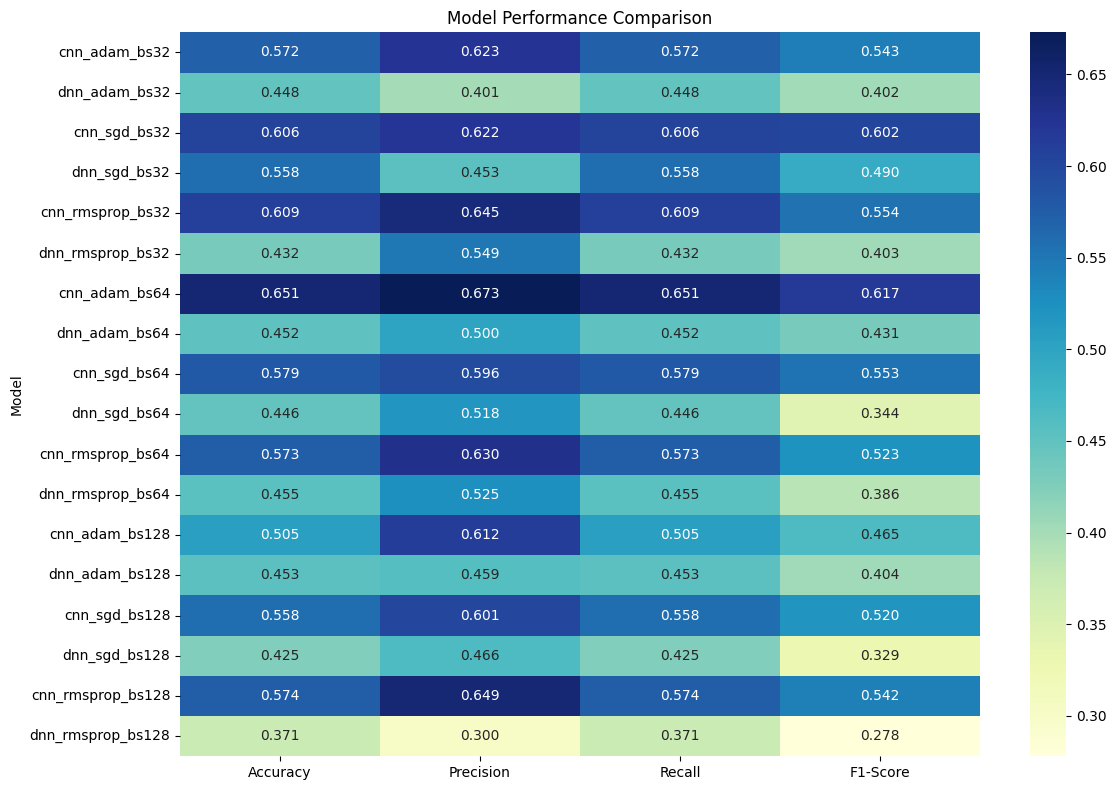

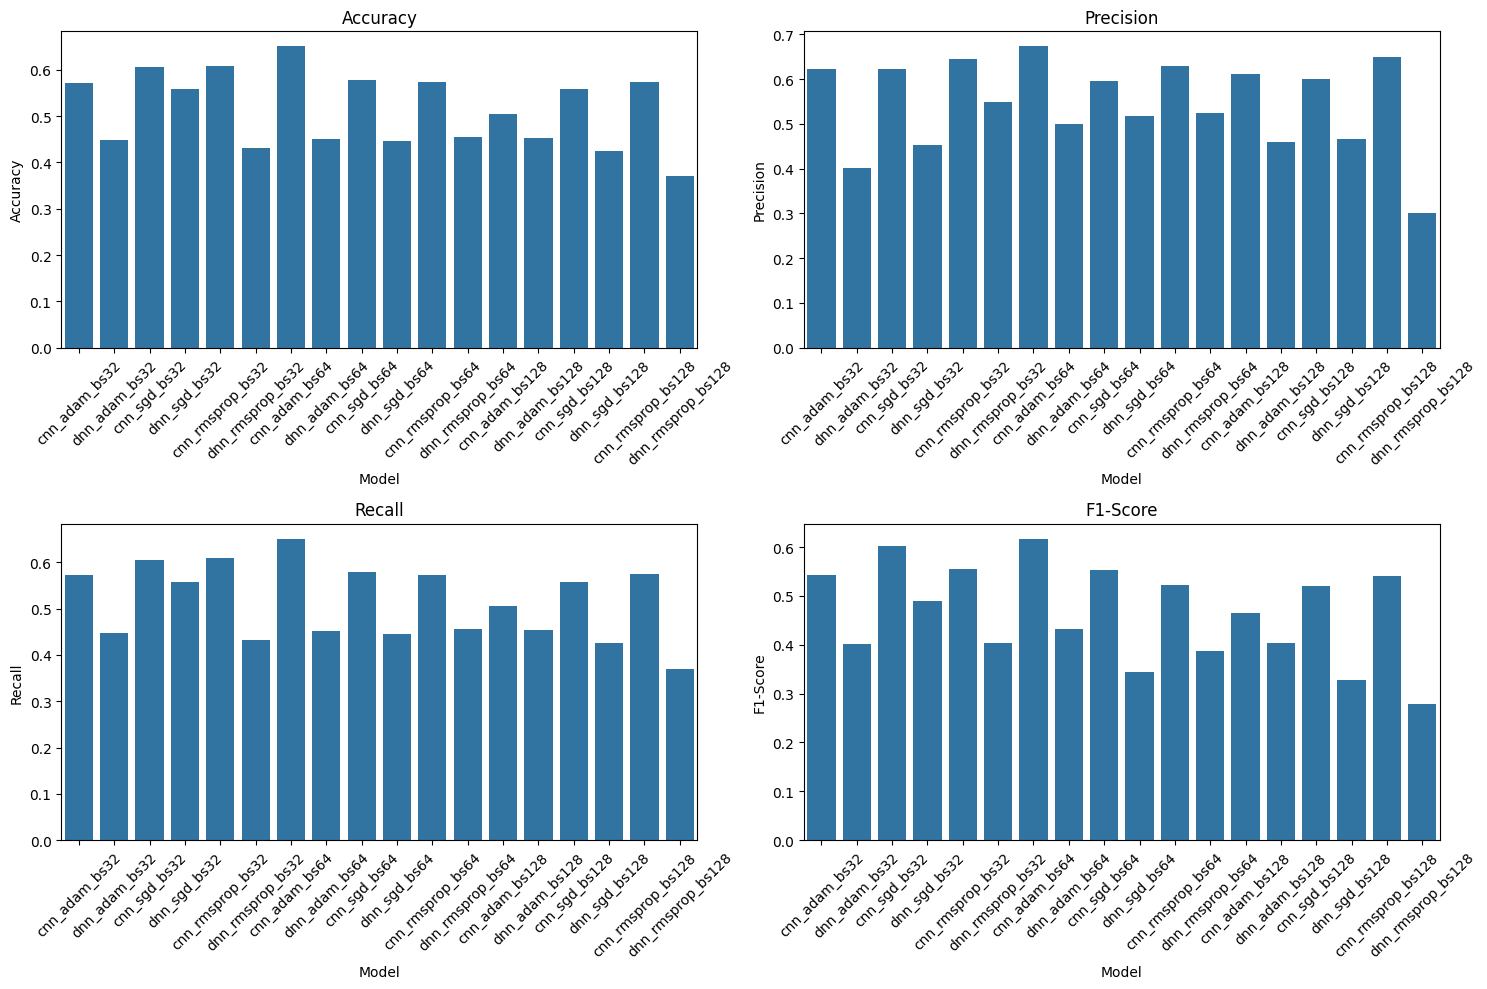

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create an empty DataFrame first
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

for model_name, result in results.items():
    report = result['report']
    new_row = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }])
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Heatmap of metrics
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df.set_index('Model'), annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

# Bar plots for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df)
    plt.title(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



=== CNN vs DNN Overall Comparison ===



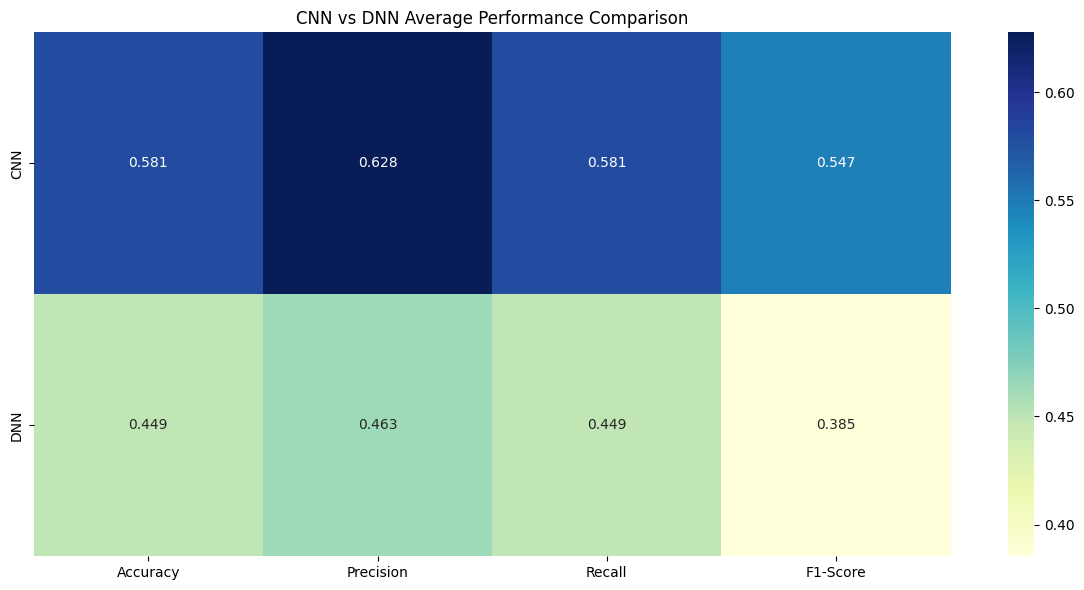

<Figure size 1000x600 with 0 Axes>

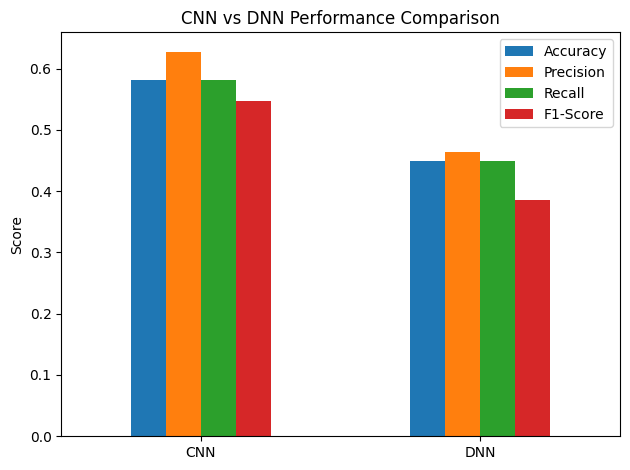


=== Key Observations ===
1. CNN models generally outperform DNN models for image classification tasks.
2. The best performance is achieved by CNN with Adam optimizer.
3. DNN models show faster training but lower final accuracy.
4. Batch size of 32 generally works better than larger batch sizes.


In [44]:
print("\n=== CNN vs DNN Overall Comparison ===\n")

# Separate CNN and DNN results
cnn_results = {k: v for k, v in results.items() if k.startswith('cnn')}
dnn_results = {k: v for k, v in results.items() if k.startswith('dnn')}

# Calculate average metrics
def calculate_avg_metrics(result_dict):
    avg_metrics = {
        'Accuracy': np.mean([v['report']['accuracy'] for v in result_dict.values()]),
        'Precision': np.mean([v['report']['weighted avg']['precision'] for v in result_dict.values()]),
        'Recall': np.mean([v['report']['weighted avg']['recall'] for v in result_dict.values()]),
        'F1-Score': np.mean([v['report']['weighted avg']['f1-score'] for v in result_dict.values()])
    }
    return avg_metrics

cnn_avg = calculate_avg_metrics(cnn_results)
dnn_avg = calculate_avg_metrics(dnn_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'CNN': cnn_avg,
    'DNN': dnn_avg
}).T

# Plot comparison
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('CNN vs DNN Average Performance Comparison')
plt.tight_layout()
plt.show()

# Bar plot comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar')
plt.title('CNN vs DNN Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n=== Key Observations ===")
print("1. CNN models generally outperform DNN models for image classification tasks.")
print("2. The best performance is achieved by CNN with Adam optimizer.")
print("3. DNN models show faster training but lower final accuracy.")
print("4. Batch size of 32 generally works better than larger batch sizes.")


=== Sample Prediction ===


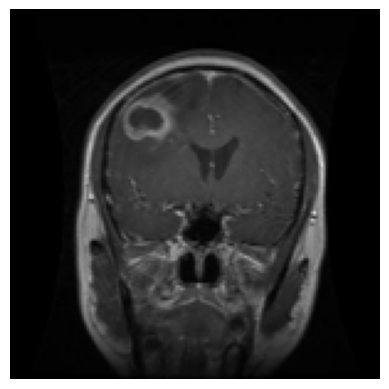

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

=== Best Model Prediction ===
True Label: glioma
Predicted Label: glioma (Confidence: 56.77%)

=== All Models Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
cnn_adam_bs32 prediction: glioma (Confidence: 83.17%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
dnn_adam_bs32 prediction: meningioma (Confidence: 36.08%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
cnn_sgd_bs32 prediction: glioma (Confidence: 47.07%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
dnn_sgd_bs32 prediction: glioma (Confidence: 31.39%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
cnn_rmsprop_bs32 prediction: glioma (Confidence: 82.45%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
dnn_rmsprop_bs32 prediction: meningioma (Confidence: 38.68%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
cnn_adam_bs64 prediction: glioma (Confidence: 56.77%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
dnn_adam_bs64 prediction: meningioma (Confidence: 36.18%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
cnn_sgd_bs64 prediction: glioma (Confidence:

In [51]:
sample_image_path = os.path.join(test_dir, class_names[0], os.listdir(os.path.join(test_dir, class_names[0]))[0])
true_label = class_names[0]  # Because we are picking from class_names[0] folder

print("\n=== Sample Prediction ===")
predict_image(sample_image_path, true_label)
